In [1]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import os
import numpy as np
import tensorflow as tf

data_path = "C://Users//GC//Desktop//food//"
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

In [3]:
train_len = 0
for i in os.listdir(train_path):
    train_len += len(os.listdir( os.path.join( train_path, i) ))

val_len = 0
for i in os.listdir(val_path):
    val_len += len(os.listdir( os.path.join( val_path, i) ))

test_len = 0
for i in os.listdir(test_path):
    test_len += len(os.listdir( os.path.join( test_path, i) ))

print(f"train : {train_len}, val : {val_len}, test : {test_len}")

train : 5250, val : 1750, test : 1750


In [4]:

# ImageDataGenerator를 통해 이미지를 원하는 shape으로 불러오고 augmentation 해줄 수 있음
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 0~1 정규화
data_gen = ImageDataGenerator(rescale=1./255)

# flow_from_directory를 통해서 폴더에 분류 있는 데이터들을 레이블과 함께 얻어올 수 있음
train_data = data_gen.flow_from_directory(
    train_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(200,200), batch_size=50 # 5250
)
val_data = data_gen.flow_from_directory(
    val_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(200,200), batch_size=50 # 1750
)
test_data = data_gen.flow_from_directory(
    test_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(200,200), batch_size=50 # 1750
)

Found 5250 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.


In [5]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
inception_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(200,200,3)
)

In [6]:
inception_model.trainable = False

set_trainable = False
for layer in inception_model.layers:
    if layer.name == "block8_5_mixed":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [7]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

layer1 = Flatten()(inception_model.output)
output = Dense(35, activation='softmax')(layer1)

model = Model(inception_model.input, output)

In [10]:
import keras
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(epsilon=1e-5), metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model/test8/test8+{epoch:02d}-{val_accuracy:.5f}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [11]:
history = model.fit(train_data, steps_per_epoch=5250 // 50, epochs=100,\
    validation_data=val_data, validation_steps=1750 // 50, callbacks=[model_checkpoint_callback])

Epoch 1/100
105/105 [==============================] - ETA: 0s - loss: 3.5116 - accuracy: 0.0903

C:\Users\GC\anaconda3\envs\GPU\lib\site-packages\PIL\Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\GC\anaconda3\envs\GPU\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Epoch 00001: val_accuracy improved from -inf to 0.05771, saving model to model/test8\test8+01-0.05771.h5
105/105 [==============================] - 42s 404ms/step - loss: 3.5116 - accuracy: 0.0903 - val_loss: 3.5456 - val_accuracy: 0.0577
Epoch 2/100
105/105 [==============================] - ETA: 0s - loss: 3.4653 - accuracy: 0.1364
Epoch 00002: val_accuracy improved from 0.05771 to 0.06800, saving model to model/test8\test8+02-0.06800.h5
105/105 [==============================] - 40s 377ms/step - loss: 3.4653 - accuracy: 0.1364 - val_loss: 3.5345 - val_accuracy: 0.0680
Epoch 3/100
105/105 [==============================] - ETA: 0s - loss: 3.4706 - accuracy: 0.1312
Epoch 00003: val_accuracy did not improve from 0.06800
105/105 [==============================] - 39s 371ms/step - loss: 3.4706 - accuracy: 0.1312 - val_loss: 3.5464 - val_accuracy: 0.0566
Epoch 4/100
105/105 [==============================] - ETA: 0s - loss: 3.3998 - accuracy: 0.2029
Epoch 00004: val_accuracy improved fro

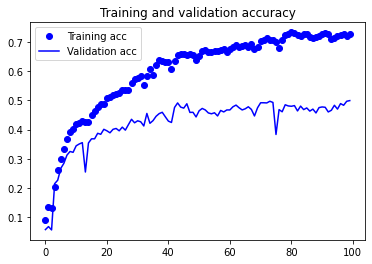

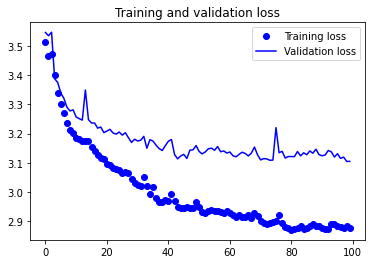

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:

model.evaluate(test_data, steps=1750//50)

35/35 [==============================] - 9s 258ms/step - loss: 3.1177 - accuracy: 0.4840


[3.1176772117614746, 0.48399999737739563]